## Imports

In [2]:
# !git clone https://github.com/facebookresearch/detr.git

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm
import pickle


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision
import torchvision.transforms as transforms

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [4]:
print(A.__version__) 

1.3.1


In [5]:
# import torch
# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark = False

In [6]:
# pickle saving example
names = ['a', 'b', 'c', 'd']
with open('testlist', 'wb') as fp:
    pickle.dump(names, fp)
    
with open ('testlist', 'rb') as fp:
    itemlist = pickle.load(fp)
    
itemlist

['a', 'b', 'c', 'd']

## Utils

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Config

In [8]:
n_folds = 5
seed = 42
num_classes = 7 #11
num_queries = 65 #changed from 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2
device = torch.device('cuda')

# OLD VERSION
# label_to_idx = {'car': 0,
#                'pedestrian': 1,
#                'truck': 2,
#                'bus': 3,
#                'bicycle': 4,
#                'rider': 5,
#                'other vehicle': 6,
#                'motorcycle': 7,
#                'other person': 8,
#                'trailer': 9,
#                'train': 10}

# idx_to_label = {0: 'car',
#                1: 'pedestrian',
#                2: 'truck',
#                3: 'bus',
#                4: 'bicycle',
#                5: 'rider',
#                6: 'other vehicle',
#                7: 'motorcycle',
#                8: 'other person',
#                9: 'trailer',
#                10: 'train'}

# NEW VERSION
label_to_idx = {'car': 0,
               'person': 1,
               'truck': 2,
               'bus': 3,
               'bicycle': 4,
               'motorcycle': 5,
               'train': 6}

idx_to_label = {0: 'car',
               1: 'person',
               2: 'truck',
               3: 'bus',
               4: 'bicycle',
               5: 'motorcycle',
               6: 'train'}

color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "person" : (255, 0, 0),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 100, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
    "train": (0, 0, 100)
}

## Seed

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

## Data Preparation

In [10]:
df = pd.read_csv('mot_labels.csv')
df['x'] = df['box2d.x1'] #(df['box2d.x1'] + df['box2d.x2'])/2
df['y'] = df['box2d.y1'] #(df['box2d.y1'] + df['box2d.y2'])/2
df['w'] = df['box2d.x2'] - df['box2d.x1']
df['h'] = df['box2d.y2'] - df['box2d.y1']
df = df[df['haveVideo'] == True].copy()
df.dropna(inplace=True)
df.head()

/tmp/ipykernel_41749/2393187165.py:1: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('mot_labels.csv')


name          videoName  frameIndex       id  \
0  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89537.0   
1  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89538.0   
2  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89539.0   
3  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89540.0   
4  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89541.0   

     category attributes.crowd attributes.occluded attributes.truncated  \
0         car            False                True                False   
1         car            False                True                False   
2  pedestrian            False                True                False   
3         car            False               False                False   
4         car            False               False                False   

     box2d.x1     box2d.x2    box2d.y1    box2d.y2  haveVideo           x  \
0  825.173210  1003.094688  355.011547  418.198614       True  825.173210   
1  484.295612   700.461894  346.697460  424.849885       True  484.295612   
2  645.588915   663.879908  338.383372  358.337182       True  645.588915   
3  120.969977   192.471132  359.168591  409.053118       True  120.969977   
4  251.501155   315.519630  354.180139  400.739030       True  251.501155   

            y           w          h  
0  355.011547  177.921478  63.187067  
1  346.697460  216.166282  78.152425  
2  338.383372   18.290993  19.953811  
3  359.168591   71.501155  49.884527  
4  354.180139   64.018476  46.558891

In [11]:
df.category.unique()

array(['car', 'pedestrian', 'truck', 'motorcycle', 'rider', 'bicycle',
       'bus', 'other vehicle', 'other person', 'train', 'trailer'],
      dtype=object)

In [12]:
def relabel(x):
    if x in ['pedestrian', 'rider', 'other person']:
        return 'person'
    return x

In [13]:
jpegs = os.listdir('frames_v2')
df_cleaned = df[df['name'].isin(jpegs)].copy()
df_cleaned = df_cleaned[~df_cleaned['category'].isin(['trailer', 'other vehicle'])]
df_cleaned['category'] = df_cleaned['category'].apply(lambda x: relabel(x))

In [14]:
df_cleaned.category.unique()

array(['car', 'truck', 'person', 'bicycle', 'bus', 'motorcycle', 'train'],
      dtype=object)

In [15]:
len(jpegs)

19519

### Train Test Split (if not done yet, otherwise import text file)

In [16]:
resampling = False

In [17]:
if resampling:
    videos = list(df_cleaned['videoName'].drop_duplicates())
    video_subset = random.sample(videos, 100)
    
    df_subset = df_cleaned[df_cleaned['videoName'].isin(video_subset)]
    
    class_counts = df_subset.groupby(['videoName', 'category']).size().unstack(fill_value=0)
    class_counts.reset_index(inplace=True)

In [18]:
# easy_videos = [
#     '003e23ee-67d25f19',
#     '012a9c41-cef5b320',
#     '00091078-59817bb0',
#     '003baca5-aab2e274',
#     '011aeca1-fe5af665'
# ]

In [19]:
if resampling:
    # Extract features and labels
    X = class_counts['videoName'].values.reshape(-1, 1)  # Features are just the video IDs
    y = class_counts.iloc[:, 1:].values  # Labels are the counts of each object class

    # Initialize the multi-label stratified shuffle splitter
    # Set test_size to the desired proportion, e.g., 0.2 for 20%
    msss = MultilabelStratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Perform the split
    train_fold_idx_list = []
    test_fold_idx_list = []
    for train_index, test_index in msss.split(X, y):
        # Split the dataframe into train and test sets based on the indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

In [20]:
if resampling:
    X_train_list = [videoName[0] for videoName in X_train]
    X_test_list = [videoName[0] for videoName in X_test]
    counts_train_df = class_counts[class_counts['videoName'].isin(X_train_list)]
    counts_test_df = class_counts[class_counts['videoName'].isin(X_test_list)]
    train_counts_df = pd.merge(df, counts_train_df, on='videoName')
    test_counts_df = pd.merge(df, counts_test_df, on='videoName')

    labels = df['category'].dropna().unique()
    train_class_distribution = train_counts_df[labels].sum().sort_index()
    test_class_distribution = test_counts_df[labels].sum().sort_index()

    print('Train Class Distribution:')
    print(train_class_distribution)
    print('-' * 30)
    print('Test Class Distribution:')
    print(test_class_distribution)

In [21]:
if resampling:
    train_class_distribution = train_counts_df['category'].value_counts(normalize=True)
    test_class_distribution = test_counts_df['category'].value_counts(normalize=True)

    # Create a DataFrame to compare the distributions
    comparison_df = pd.DataFrame({
        'Train Distribution': train_class_distribution,
        'Test Distribution': test_class_distribution
    })

    print(comparison_df)

In [22]:
if resampling:
    print(len(X_train_list), len(X_test_list))

In [23]:
if resampling:
    train_series = pd.Series(X_train_list)
    test_series = pd.Series(X_test_list)

    train_series.to_csv('train_videos_small.csv')
    test_series.to_csv('test_videos_small.csv')

### Train Test Split Import

In [24]:
X_train_df = pd.read_csv('train_videos_small.csv', header = None, index_col = 0)
X_test_df = pd.read_csv('test_videos_small.csv', header = None, index_col = 0)

X_train_list = list(X_train_df[1])
X_test_list = list(X_test_df[1])

len(X_train_list), len(X_test_list)

(80, 20)

In [25]:
train_df = df_cleaned[df_cleaned['videoName'].isin(X_train_list)].copy()
test_df = df_cleaned[df_cleaned['videoName'].isin(X_test_list)].copy()

In [26]:
train_df.head()

name          videoName  frameIndex        id  \
89752  003e23ee-67d25f19-0000002.jpg  003e23ee-67d25f19           1  106589.0   
89753  003e23ee-67d25f19-0000002.jpg  003e23ee-67d25f19           1  106590.0   
89754  003e23ee-67d25f19-0000002.jpg  003e23ee-67d25f19           1  106591.0   
89755  003e23ee-67d25f19-0000002.jpg  003e23ee-67d25f19           1  106592.0   
89756  003e23ee-67d25f19-0000002.jpg  003e23ee-67d25f19           1  106593.0   

      category attributes.crowd attributes.occluded attributes.truncated  \
89752      car            False               False                False   
89753      car            False                True                 True   
89754      car            False               False                 True   
89755      car            False                True                False   
89756      car            False                True                False   

         box2d.x1     box2d.x2    box2d.y1    box2d.y2  haveVideo           x  \
89752  204.398952   660.434731  196.266663  518.101687       True  204.398952   
89753  654.056608  1280.000000  201.599996  534.046994       True  654.056608   
89754    1.088867    60.917954  278.099695  387.422167       True    1.088867   
89755   35.298719    85.447009  285.846067  359.433232       True   35.298719   
89756  151.767453   253.360054  279.583524  400.711107       True  151.767453   

                y           w           h  
89752  196.266663  456.035779  321.835024  
89753  201.599996  625.943392  332.446998  
89754  278.099695   59.829087  109.322472  
89755  285.846067   50.148290   73.587165  
89756  279.583524  101.592601  121.127583

In [27]:
# THIS IS WRONG-IGNORE FOR NOW
# easy_videos = [
#     '003e23ee-67d25f19',
#     '012a9c41-cef5b320',
#     '00091078-59817bb0',
#     '003baca5-aab2e274',
#     '011aeca1-fe5af665'
# ]

## Augmentations

In [28]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),
                      
                      #A.augmentations.geometric.resize.LongestMaxSize(max_size=64, p=1),

                      #A.Resize(height=512, width=512, p=0), #changed to p=0 from p=1 to get rid of it

                      #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      ) # changed from coco to yolo

## Creating a Dataset Class

In [29]:
def normalize_boxes(boxes, img_width, img_height):
    normalized_boxes = []
    for box in boxes:
        x_min, y_min, w, h = box
        cx = x_min + (w/2)
        cy = y_min + (h/2)
        cx_normalized = cx / img_width
        cy_normalized = cy / img_height
        w_normalized = w / img_width
        h_normalized = h / img_height
        normalized_boxes.append((cx_normalized, cy_normalized, w_normalized, h_normalized))
    return normalized_boxes

In [30]:
DIR_TRAIN = 'frames_v2'

class DrivingDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        self.label_map = {'car': 0,
                   'person': 1,
                   'truck': 2,
                   'bus': 3,
                   'bicycle': 4,
                   'motorcycle': 5,
                   'train': 6}

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['name'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR).astype(np.float32)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # DETR takes in data in coco format
        boxes = records[['x', 'y', 'w', 'h']].values

        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels = records['category'].values
        labels =  np.array([self.label_map[label] for label in labels], dtype=np.int32)


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']


        #Normalizing BBOXES

        _,h,w = image.shape
        boxes = normalize_boxes(sample['bboxes'], w, h) #A.core.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

# train_dataset = DrivingDataset(image_ids=train_df.name.values, 
#                                dataframe=train_df, 
#                                transforms=get_train_transforms())

# train_data_loader = DataLoader(train_dataset, 
#                                batch_size=BATCH_SIZE, 
#                                shuffle=False, 
#                                #num_workers=4, 
#                                collate_fn= collate_fn)

## Model

In [32]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

## Matching and Bipartite Loss

In [33]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

## Training

In [34]:
import sys

def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()
    loss_per_batch = []
    
    num_batches = len(data_loader)

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets, image_ids) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        loss_per_batch.append(summary_loss.avg)
        tk0.set_postfix(loss=summary_loss.avg)
        
        if step+1 % int(num_batches/4) == 0:
            torch.save(model.state_dict(), 'detr2_parameters.pth')
            with open('detr2_train_losses_partial', 'wb') as fp:
                pickle.dump(loss_per_batch, fp)
        
        torch.cuda.empty_cache()
        del loss_dict, losses

    return summary_loss, loss_per_batch

## Eval

In [35]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
            
            torch.cuda.empty_cache()
            del loss_dict, losses
            
    return summary_loss

## Testing / exploring

In [36]:
# train_dataset = DrivingDataset(image_ids=train_df.name.values, 
#                                dataframe=train_df, 
#                                transforms=get_train_transforms())

# train_data_loader = DataLoader(train_dataset, 
#                                batch_size=BATCH_SIZE, 
#                                    shuffle=True, #False, 
#                                    #num_workers=4, 
#                                    collate_fn= collate_fn)

In [37]:
# def visualize_batch(data_loader):
#     images, targets, image_ids = next(iter(data_loader))
#     fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#     print(image_ids)
#     for i in range(4):
#         img = images[i].numpy().transpose(1, 2, 0)
#         print(img.shape)
#         ax[i].imshow(img)
#         ax[i].axis('off')
#     plt.show()
    
# visualize_batch(train_data_loader)

In [38]:
# img = cv2.imread('frames_v2/018bf09d-cd788942-0000085.jpg')
# print(img.shape)
# plt.imshow(img)

In [39]:
# img_rs = cv2.resize(img, (128, 72))
# plt.imshow(img_rs)

## Pre-trained DETR

### Viewing Sample Images with Bounding Boxes from Pre-trained DETR

In [40]:
def view_sample(df,model,device, save_fig = None):
    '''
    Code taken from Peter's Kernel
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    dataset = DrivingDataset(image_ids=df.name.values, 
                            dataframe=df, 
                            transforms=get_valid_transforms())

    data_loader = DataLoader(dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, #False, 
                            #num_workers=4, 
                            collate_fn= collate_fn)

    images, targets, image_ids = next(iter(data_loader))
    _,h,w = images[0].shape # for de normalizing images

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
#     sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR).astype(np.float32)

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cx, cy, bw, bh = box
        cv2.rectangle(sample,
                  (cx-int(bw/2), cy-int(bh/2)),
                  (cx+int(bw/2), cy+int(bh/2)),
                  (220, 0, 0), 1)


    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    logits = outputs[0]['pred_logits'][0].detach().cpu().numpy()
    
    for box, logit in zip(oboxes, logits):
        prob = torch.softmax(torch.from_numpy(logit), dim=0).numpy()
        class_idx = np.argmax(prob[:-1])  # Exclude the last class (no-object)
        p = prob[class_idx]
        max_p = 0
        if p > max_p:
            max_p = p
        
        if p > 0.4: 
            label = idx_to_label[class_idx]
            cx, cy, bw, bh = box
            cv2.rectangle(sample,
                          (cx-int(bw/2), cy-int(bh/2)),
                          (cx+int(bw/2), cy+int(bh/2)),
                          (0, 0, 255), 1)
            cv2.putText(sample, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    ax.set_axis_off()
    ax.imshow(sample)
    if save_fig:
        plt.savefig(f'{save_fig}-{image_ids[0]}.png')
    plt.show()
    
    print(max_p)
    print(image_ids)

In [41]:
# device = torch.device('cuda')
# model = DETRModel(num_classes=num_classes,num_queries=num_queries)
# model = model.to(device)

# for i in range(5):
#     view_sample(test_df, model, device)

### Performance of Test Set on Pre-Trained DETR

In [42]:
# test_dataset = DrivingDataset(image_ids=test_df.name.values, 
#                               dataframe=test_df,
#                               transforms=get_valid_transforms())

# test_data_loader = DataLoader(test_dataset, 
#                                batch_size=64, 
#                                shuffle=True, #False, 
#                                #num_workers=4, 
#                                collate_fn= collate_fn)

# print('test data loader made')


# device = torch.device('cuda')
# model = DETRModel(num_classes=num_classes,num_queries=num_queries)
# model = model.to(device)
# criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses) #changed from num_classes-1 to num_classes
# criterion = criterion.to(device)

# valid_loss = eval_fn(test_data_loader, model,criterion, device)

In [43]:
# print(f'Test loss on the pre-trained DETR: {valid_loss.avg}')

In [44]:
# Saving Loss value from test set on pre-trained DETR for when the output gets lost ^ 
# also the above is commented out for when running the bigger training model later in TMUX to save time
print('Test loss on the pre-trained DETR: 2.7477256315352334')

Test loss on the pre-trained DETR: 2.7477256315352334


## Engine

In [47]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


train_dataset = DrivingDataset(image_ids=train_df.name.unique(), 
                               dataframe=train_df, 
                               transforms=get_train_transforms())

train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

print('train data loader made')

test_dataset = DrivingDataset(image_ids=test_df.name.unique(), 
                              dataframe=test_df,
                              transforms=get_valid_transforms())

test_data_loader = DataLoader(test_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

print('test data loader made')


device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses) #changed from num_classes-1 to num_classes
criterion = criterion.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_loss = 10**5
train_losses = []
test_losses = []
train_batch_losses = []
for epoch in range(EPOCHS):
    train_loss, loss_by_batch = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
    
    torch.save(model.state_dict(), 'detr2_parameters.pth')
    with open(f'detr2_train_losses_by_batch_{epoch}', 'wb') as fp:
        pickle.dump(loss_by_batch, fp)
    
    valid_loss = eval_fn(test_data_loader, model,criterion, device)

    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    train_losses.append(train_loss.avg)
    train_batch_losses.append(loss_by_batch)
    test_losses.append(valid_loss.avg)
    
    with open('detr2_train_losses', 'wb') as fp:
        pickle.dump(train_losses, fp)
    
    with open('detr2_test_losses', 'wb') as fp:
        pickle.dump(test_losses, fp)


#         if valid_loss.avg < best_loss:
#             best_loss = valid_loss.avg
#             print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
#             torch.save(model.state_dict(), f'detr_best_{fold}.pth')

train data loader made
test data loader made


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_detr_main
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 476/476 [02:48<00:00,  2.83it/s, loss=0.865]


|EPOCH 1| TRAIN_LOSS 0.9488094358100104| VALID_LOSS 0.8654878759334067|


100%|██████████| 476/476 [02:47<00:00,  2.84it/s, loss=0.878]

|EPOCH 2| TRAIN_LOSS 0.8368228644747095| VALID_LOSS 0.8782933473336596|


In [48]:
torch.save(model.state_dict(), 'detr3_parameters.pth')

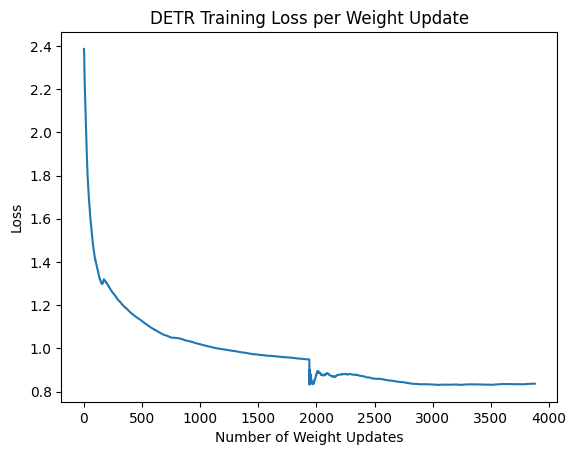

In [49]:
loss_per_weight_update = np.concatenate(train_batch_losses)
plt.plot(loss_per_weight_update)
plt.xlabel('Number of Weight Updates')
plt.ylabel('Loss')
plt.title('DETR Training Loss per Weight Update')
plt.savefig('detr2_training_loss_plot.png')
plt.show()

### Visualizing Trained DETR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


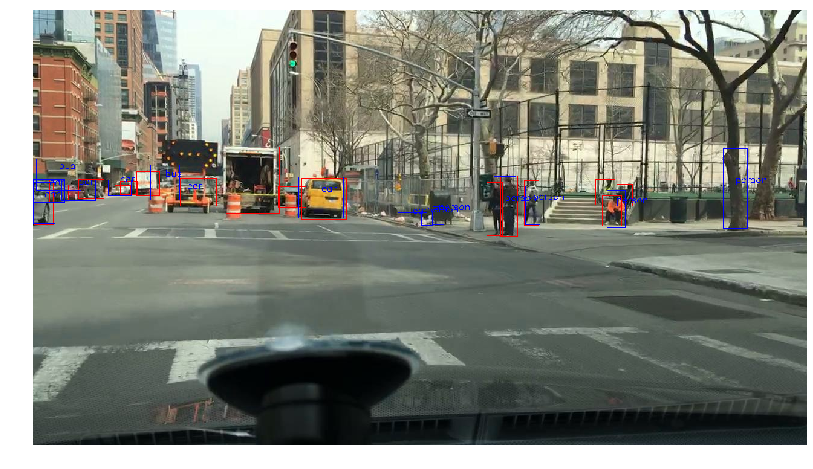

0.13084534
('0062f18d-f8cd3a65-0000030.jpg', '00b93c6e-6298aa25-0000148.jpg', '029ad1d1-2f5ad804-0000092.jpg', '02778d17-efa6d1ee-0000051.jpg', '02a70c1f-6df7ce64-0000098.jpg', '00b93c6e-6298aa25-0000172.jpg', '01fe8b93-102f9fe0-0000033.jpg', '029ad1d1-2f5ad804-0000189.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


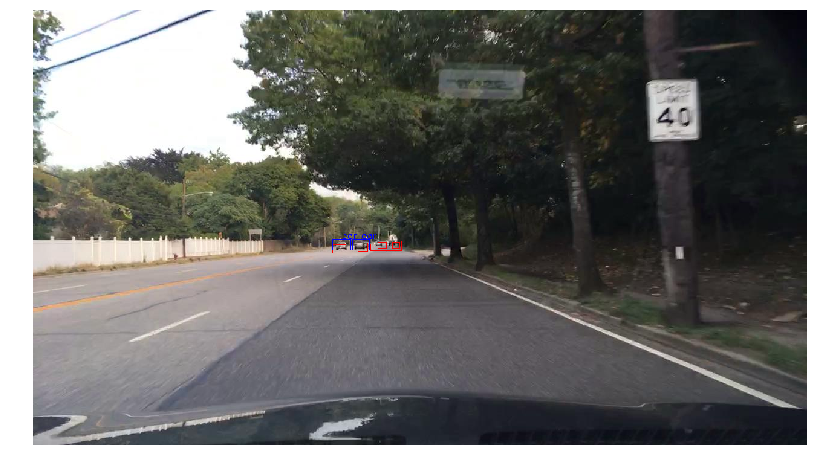

0.26630908
('02494b7b-079febf8-0000010.jpg', '00a820ef-d655700e-0000056.jpg', '02a70c1f-6df7ce64-0000137.jpg', '02778d17-efa6d1ee-0000052.jpg', '029ad1d1-2f5ad804-0000071.jpg', '007aeb45-3e75ce0e-0000190.jpg', '01af2f91-7bd5e6c9-0000177.jpg', '029ad1d1-2f5ad804-0000069.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


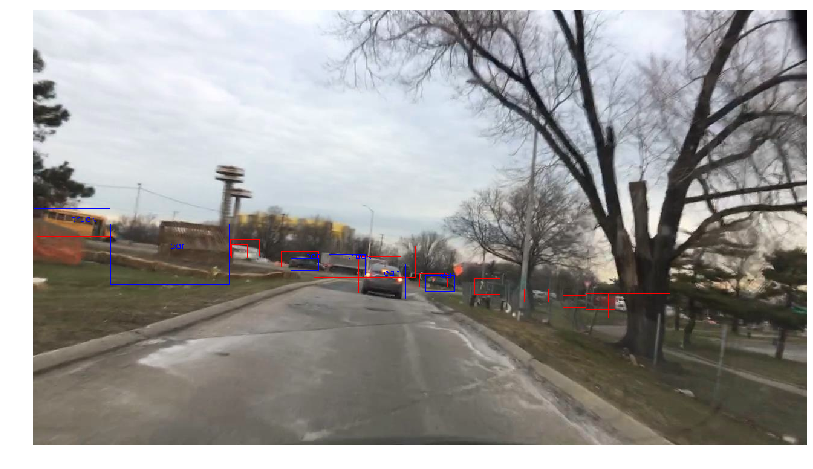

0.878464
('029ad1d1-2f5ad804-0000065.jpg', '0062f18d-f8cd3a65-0000010.jpg', '002d290d-89f4e5c0-0000162.jpg', '01fe8b93-102f9fe0-0000075.jpg', '00a820ef-d655700e-0000025.jpg', '01fe8b93-102f9fe0-0000024.jpg', '01fe8b93-102f9fe0-0000063.jpg', '00825605-9dcec7d0-0000199.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


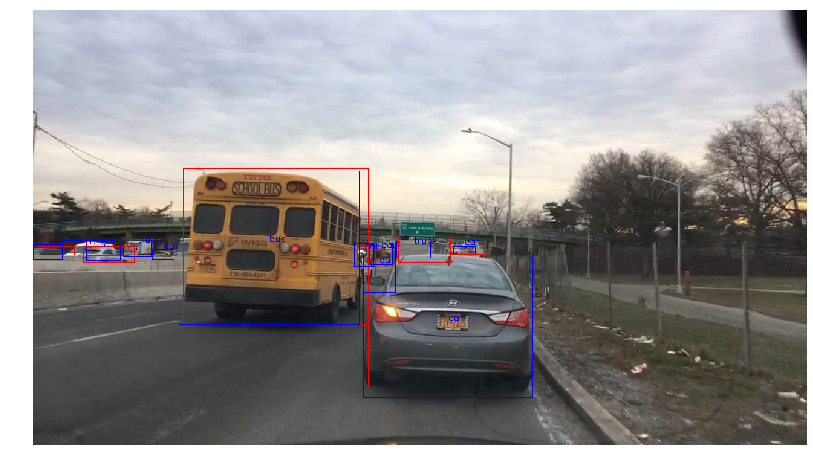

0.04630719
('029ad1d1-2f5ad804-0000111.jpg', '007aeb45-3e75ce0e-0000006.jpg', '01fe8b93-102f9fe0-0000002.jpg', '007aeb45-3e75ce0e-0000016.jpg', '029ad1d1-2f5ad804-0000130.jpg', '007aeb45-3e75ce0e-0000019.jpg', '01fe8b93-102f9fe0-0000004.jpg', '015ccf71-4b65f4bf-0000086.jpg')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


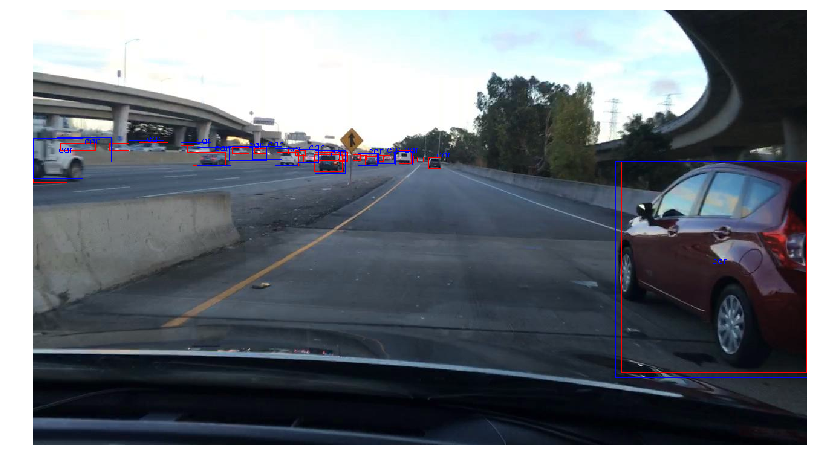

0.015143751
('02a70c1f-6df7ce64-0000120.jpg', '00b93c6e-6298aa25-0000181.jpg', '00a820ef-d655700e-0000166.jpg', '01fe8b93-102f9fe0-0000174.jpg', '0035afff-bd191d6a-0000119.jpg', '019d0e2f-26b8c896-0000148.jpg', '0062f18d-f8cd3a65-0000057.jpg', '029ad1d1-2f5ad804-0000200.jpg')


In [50]:
for i in range(5):
    view_sample(test_df, model, device, 'DETR2_trained_results/DETR2_plots/detr-trained')

### Video Specific DETR Exploration

In [60]:
sample_vid = X_test_list[4]

In [54]:
vid = X_test_list[2]
vid

'0062f18d-f8cd3a65'

In [53]:
ipd.Video(f'bdd100k_videos_train_00/bdd100k/videos/train/{vid}.mov', width=700)

In [62]:
one_video_sample_df = test_df[test_df['videoName'] == sample_vid]

In [63]:
one_vid_dataset = DrivingDataset(image_ids=one_video_sample_df.name.values, 
                               dataframe=one_video_sample_df, 
                               transforms=get_valid_transforms())

In [64]:
one_vid_dataset[0]

(tensor([[[0.3098, 0.3059, 0.3176,  ..., 0.2510, 0.2510, 0.2510],
          [0.3765, 0.3686, 0.3608,  ..., 0.2510, 0.2510, 0.2510],
          [0.3961, 0.3961, 0.3922,  ..., 0.2510, 0.2510, 0.2510],
          ...,
          [0.1725, 0.1725, 0.1725,  ..., 0.8941, 0.8863, 0.8863],
          [0.1529, 0.1529, 0.1529,  ..., 0.9137, 0.9020, 0.8941],
          [0.1373, 0.1373, 0.1373,  ..., 0.9137, 0.9137, 0.9059]],
 
         [[0.4039, 0.4000, 0.4118,  ..., 0.5098, 0.5098, 0.5098],
          [0.4706, 0.4627, 0.4549,  ..., 0.5098, 0.5098, 0.5098],
          [0.4902, 0.4902, 0.4863,  ..., 0.5098, 0.5098, 0.5098],
          ...,
          [0.2314, 0.2314, 0.2314,  ..., 0.9176, 0.9137, 0.9137],
          [0.2118, 0.2118, 0.2118,  ..., 0.9176, 0.9137, 0.9137],
          [0.1961, 0.1961, 0.1961,  ..., 0.9176, 0.9137, 0.9137]],
 
         [[0.5216, 0.5176, 0.5294,  ..., 0.7882, 0.7882, 0.7882],
          [0.5882, 0.5804, 0.5725,  ..., 0.7882, 0.7882, 0.7882],
          [0.6000, 0.6000, 0.5961,  ...,

In [47]:
def plot_model_output(output, img, target, image_id, save_fig = None):
    
    _,h,w = img.shape
    
    boxes = target['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = img.permute(1,2,0).cpu().numpy() #img.permute(1,2,0).cpu().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
#         print(box)
#         print()
        cx, cy, bw, bh = box
        cv2.rectangle(sample,
                  (cx-int(bw/2), cy-int(bh/2)),
                  (cx+int(bw/2), cy+int(bh/2)),
                  (220, 0, 0), 1)


    oboxes = output['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    logits = output['pred_logits'][0].detach().cpu().numpy()
    
    for box, logit in zip(oboxes, logits):
        prob = torch.softmax(torch.from_numpy(logit), dim=0).numpy()
        class_idx = np.argmax(prob[:-1])  # Exclude the last class (no-object)
        p = prob[class_idx]
        max_p = 0
        if p > max_p:
            max_p = p
        
        if p > 0.4: 
            label = idx_to_label[class_idx]
            cx, cy, bw, bh = box
#             print(box)
            cv2.rectangle(sample,
                  (cx-int(bw/2), cy-int(bh/2)),
                  (cx+int(bw/2), cy+int(bh/2)),
                  (0, 0, 220), 1)
            cv2.putText(sample, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    ax.set_axis_off()
    ax.imshow(sample)
    if save_fig:
        plt.savefig(f'{save_fig}-{image_id}.png')
    plt.show()

In [66]:
start_time = time.time()

def run_one_vid(dataset):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(dataset, total=len(dataset), position=0, leave=True)
        for step, (image, target, image_id) in enumerate(tk0):
            image = [image.to(device)]
            target =  [{k: v.to(device) for k, v in target.items()}]
            output = model(image)

            loss_dict = criterion(output, target)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

            torch.cuda.empty_cache()
            del loss_dict, losses
    
    return summary_loss

In [67]:
summary_loss = run_one_vid(one_vid_dataset)
end_time = time.time()
print(f'One video execution time: {end_time - start_time}')
print('One video loss: ', summary_loss.avg)

100%|██████████| 1477/1477 [02:05<00:00, 11.83it/s, loss=0.893]

One video execution time: 159.3580675125122
One video loss:  0.8933223595914602


In [68]:
print('One video loss: ', summary_loss.avg)

One video loss:  0.8933223595914602


In [69]:
# Saved in case lost 
print('One video execution time: 159.3580675125122')
print('One video loss: 0.8933223595914602')

One video execution time: 159.3580675125122
One video loss: 0.8933223595914602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


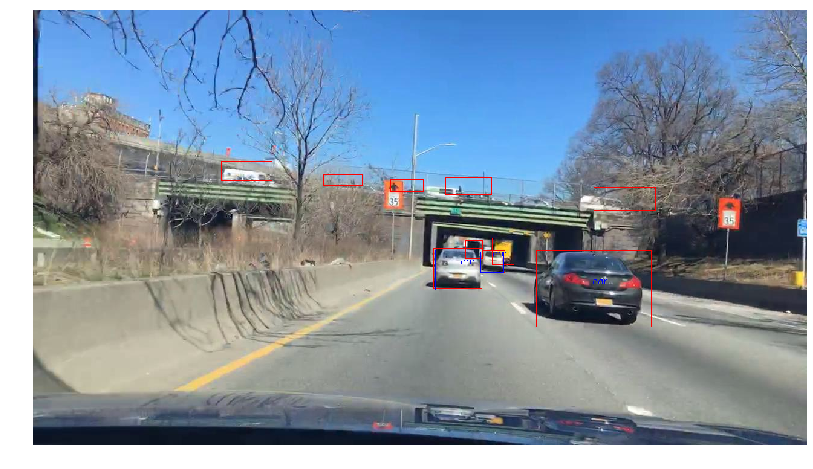

0.9574522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


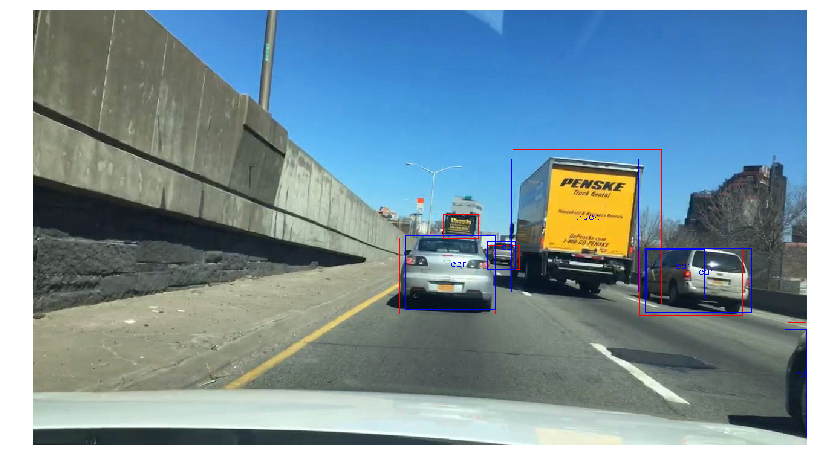

0.9525734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


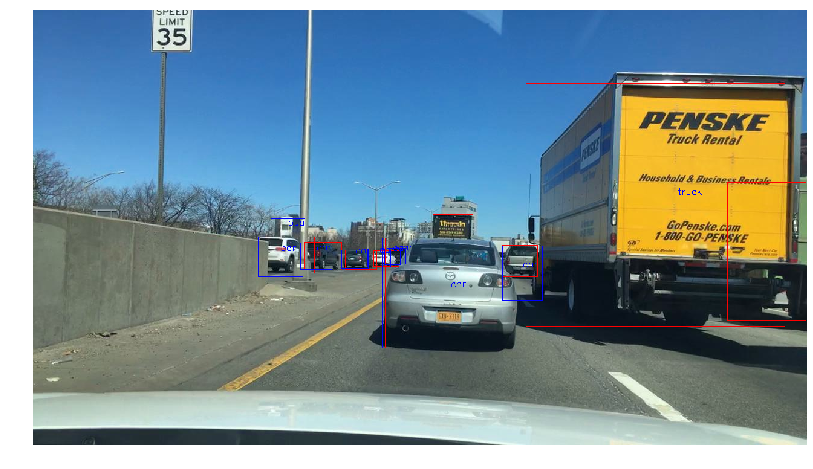

0.8893761


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


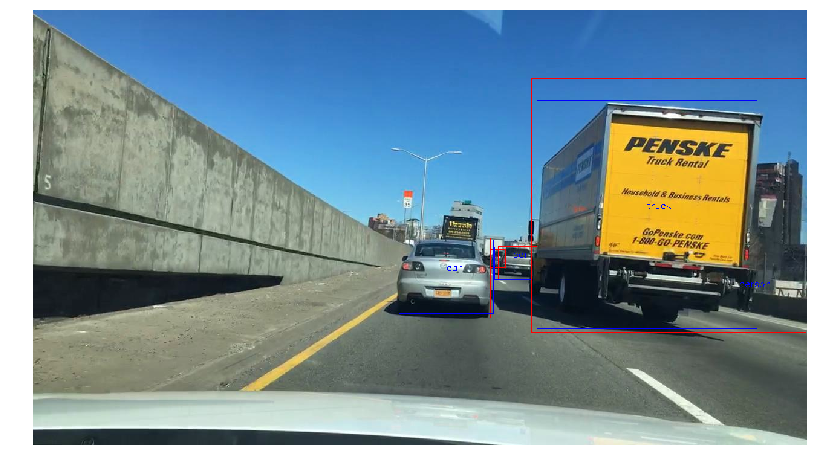

0.9745248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


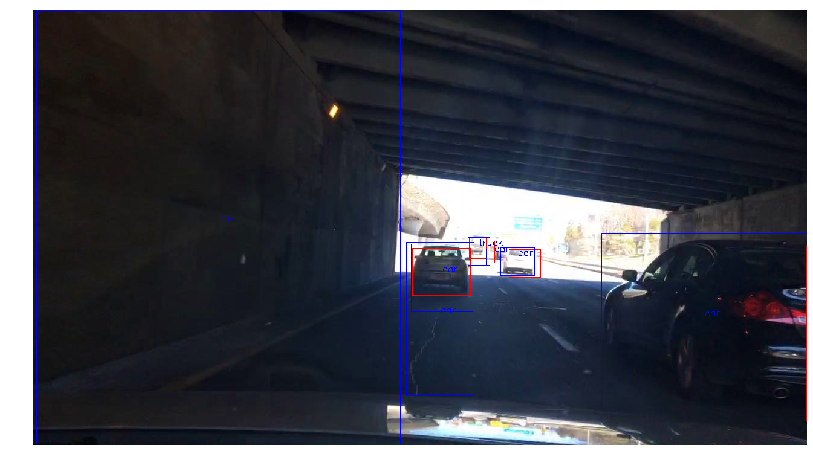

0.07155915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


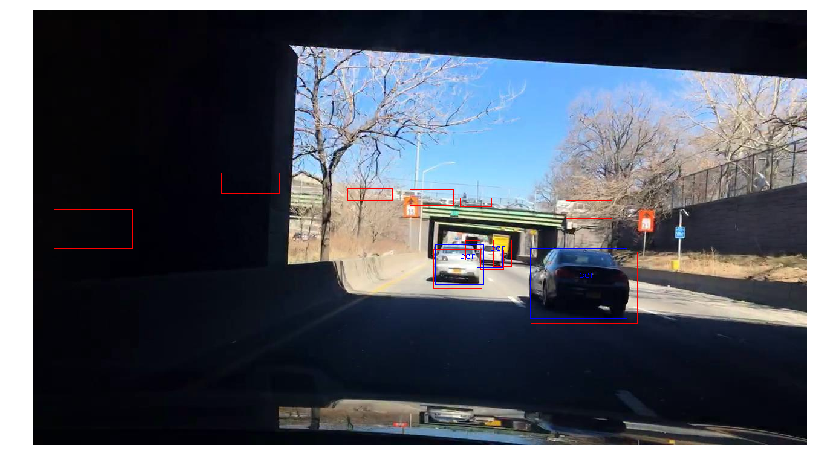

0.98840487


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


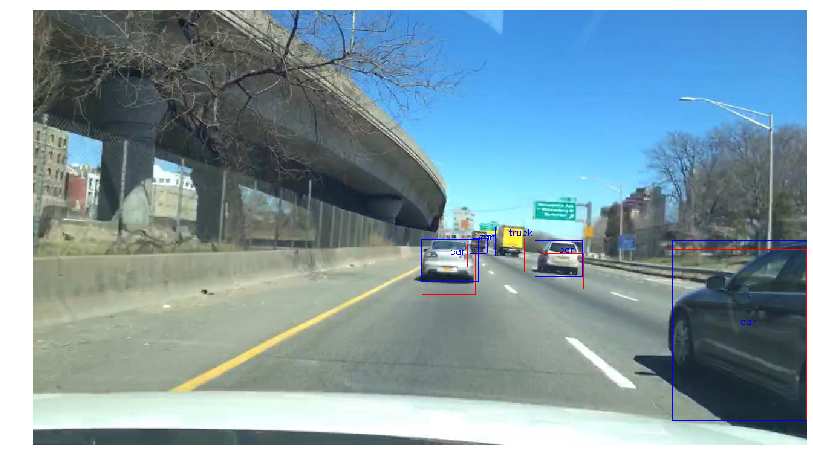

0.076441824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


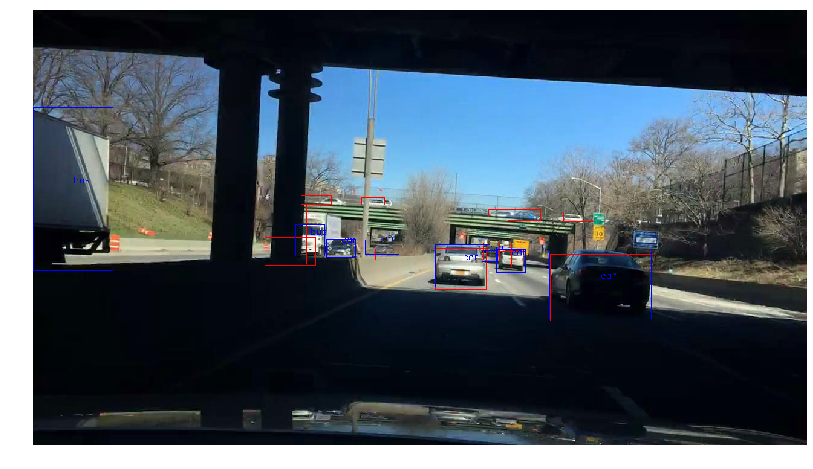

0.03837117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


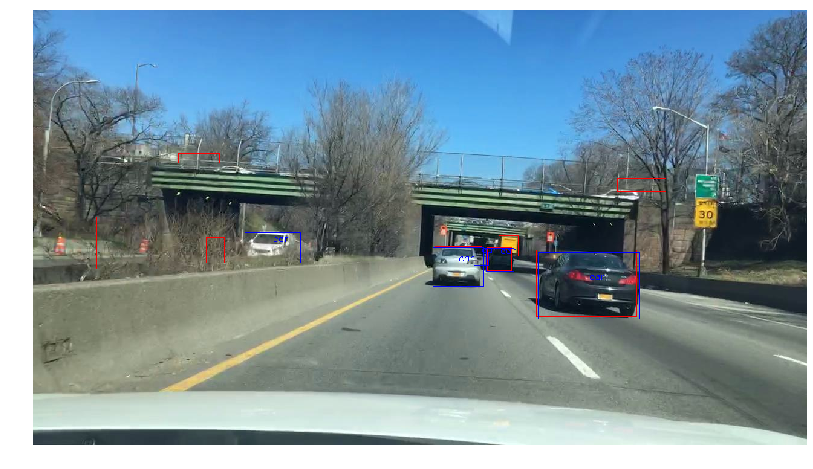

0.63398033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


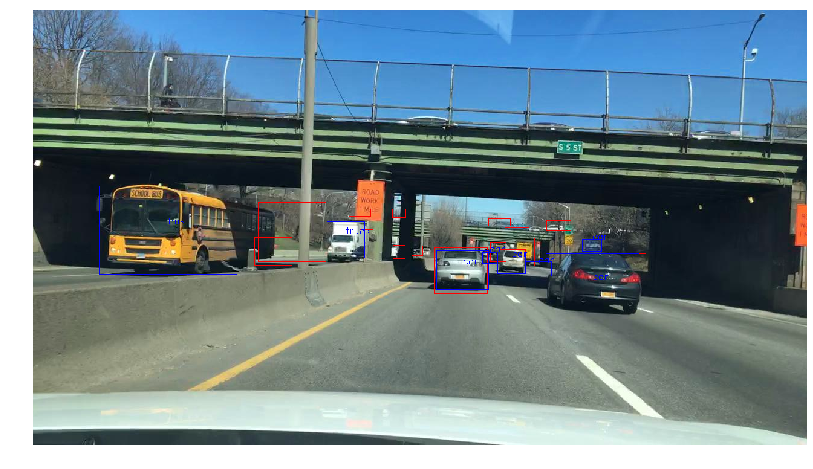

0.98087066


In [75]:
# for i, (img, target, img_id) in enumerate(one_vid_dataset):
#     img = [img.to(device)]
# #     target =  [{k: v.to(device) for k, v in target.items()}]
#     output = model(img)
#     plot_model_output(output, img[0], target, img_id, 'DETR2_trained_results/DETR2_plots/sample_vid/detr-trained')
#     if i > 10:
#         break

for i in range(10):
    view_sample(one_video_sample_df, model, device, 'DETR2_trained_results/DETR2_plots/sample_vid/detr-trained')

## MAP for Detr

In [41]:
device = torch.device("cuda")
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load('detr2_parameters.pth'))
model.to(device)

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses) #changed from num_classes-1 to num_classes
criterion = criterion.to(device)

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_detr_master


In [42]:
test_dataset = DrivingDataset(image_ids=test_df.name.values, 
                              dataframe=test_df,
                              transforms=get_valid_transforms())

test_data_loader = DataLoader(test_dataset, 
                               batch_size=64, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

In [76]:
def box_iou(box1, box2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box1[0] - box1[2] / 2, box2[0] - box2[2] / 2)
    yA = max(box1[1] - box1[3] / 2, box2[1] - box2[3] / 2)
    xB = min(box1[0] + box1[2] / 2, box2[0] + box2[2] / 2)
    yB = min(box1[1] + box1[3] / 2, box2[1] + box2[3] / 2)

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    box1Area = box1[2] * box1[3]
    box2Area = box2[2] * box2[3]

    # Compute the intersection over union
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def calculate_iou_matrix(boxes1, boxes2):
    iou_matrix = np.zeros((len(boxes1), len(boxes2)))
    for i, box1 in enumerate(boxes1):
        for j, box2 in enumerate(boxes2):
            iou_matrix[i, j] = box_iou(box1, box2)
    return iou_matrix

def compute_precision_recall(iou_matrix, num_pred, num_actual, iou_threshold=0.5):
#     iou_matrix = calculate_iou_matrix(predicted_boxes, ground_truth_boxes)
    true_positives = (iou_matrix.max(axis = 1) >= iou_threshold).sum()
    precision = true_positives / num_pred
    recall = min(true_positives, num_actual) / num_actual
    return precision, recall

def compute_average_precision(predicted_boxes, ground_truth_boxes):
    iou_matrix = calculate_iou_matrix(predicted_boxes, ground_truth_boxes)
    thresholds = np.linspace(0, 1, 11)
    precisions = []
    recalls = []
    ts = []
    
    num_pred = len(predicted_boxes)
    num_actual = len(ground_truth_boxes)
    
    for i, t in enumerate(thresholds):
        precision, recall = compute_precision_recall(iou_matrix, num_pred, num_actual, t)
        if (precision in precisions) or (recall in recalls):
            continue
        precisions.append(precision)
        recalls.append(recall)
        ts.append(t)
#         print(t, recall, precision)
     
    r = np.array(recalls)
    p = np.array(precisions)
    sort_idx = np.argsort(r)
    r_sorted = r[sort_idx]
    p_sorted = p[sort_idx]
    
    # Compute the area under the precision-recall curve
    ap = np.trapz(r_sorted, p_sorted)
    return ap

def compute_map(prediction, target):
    target_boxes = target['boxes'].numpy()
    target_boxes_denorm = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(target_boxes,h,w)]
    target_labels = target['labels'].numpy()
    
    pred_boxes = np.array(prediction['boxes'])
    pred_labels = np.array(prediction['labels'])
    
    aps = []
    
    #class consolidation
    classes = [[0, 2, 3, 5], [1], [4], [6]]
    
    for i in classes:
        class_target_idx = np.isin(target_labels, i)
        class_targets = target_boxes[class_target_idx]
        
        class_pred_idx = np.isin(pred_labels, i)
        class_preds = pred_boxes[class_pred_idx]
        
        if len(class_targets) == 0:
#             aps.append(-1)
            continue
        
        if len(class_preds) == 0:
            aps.append(0)
            continue
        
        ap = compute_average_precision(class_preds, class_targets)
        aps.append(ap)
        
    return np.mean(aps)

In [44]:
# Returns Loss and Boxes predicted over 0.4
def get_DETR_pred(image, target, image_id, model, criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = 0
    
    with torch.no_grad():

        image = [image.to(device)]
        target =  [{k: v.to(device) for k, v in target.items()}]
        output = model(image)

        loss_dict = criterion(output, target)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        summary_loss = losses.item()

        torch.cuda.empty_cache()
        del loss_dict, losses
      
    _,h,w = image[0].shape
    oboxes = output['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    logits = output['pred_logits'][0].detach().cpu().numpy()
    
    output_boxes = []
    output_labels = []
    
    for box, logit in zip(oboxes, logits):
        prob = torch.softmax(torch.from_numpy(logit), dim=0).numpy()
        class_idx = np.argmax(prob[:-1])  # Exclude the last class (no-object)
        p = prob[class_idx]
        
        if p > 0.4: 
            output_boxes.append(box)
            output_labels.append(class_idx)
    
    return summary_loss, {'boxes': output_boxes, 'labels': output_labels}

In [91]:
sample_vid = '0062f18d-f8cd3a65'
one_video_sample_df = test_df[test_df['videoName'] == sample_vid]

one_vid_dataset = DrivingDataset(image_ids=one_video_sample_df.name.unique(), 
                               dataframe=one_video_sample_df, 
                               transforms=get_valid_transforms())

In [92]:
len(one_vid_dataset)

101

In [93]:
len(one_vid_dataset)

101

In [97]:
aps = []
for i, (img, target, img_id) in tqdm(enumerate(one_vid_dataset), total = len(one_vid_dataset)):
    image = [img.to(device)]
    output = model(image)
#     plot_model_output(output, image[0], target, img_id)

    _, h, w = img.shape
    target_boxes = target['boxes']
    denorm_targets = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(target_boxes,h,w)]

    loss, prediction = get_DETR_pred(img, target, img_id, model, criterion, device)
    ap = compute_map(prediction, target)
    aps.append(ap)



  0%|          | 0/101 [00:00<?, ?it/s]

  1%|          | 1/101 [00:00<00:13,  7.51it/s]

  2%|▏         | 2/101 [00:00<00:13,  7.44it/s]

  3%|▎         | 3/101 [00:00<00:13,  7.42it/s]

  4%|▍         | 4/101 [00:00<00:13,  7.43it/s]

  5%|▍         | 5/101 [00:00<00:12,  7.50it/s]

  6%|▌         | 6/101 [00:00<00:12,  7.48it/s]

  7%|▋         | 7/101 [00:00<00:12,  7.50it/s]

  8%|▊         | 8/101 [00:01<00:12,  7.47it/s]

  9%|▉         | 9/101 [00:01<00:12,  7.53it/s]

 10%|▉         | 10/101 [00:01<00:12,  7.54it/s]

 11%|█         | 11/101 [00:01<00:11,  7.56it/s]

 12%|█▏        | 12/101 [00:01<00:11,  7.59it/s]

 13%|█▎        | 13/101 [00:01<00:11,  7.60it/s]

 14%|█▍        | 14/101 [00:01<00:11,  7.58it/s]

 15%|█▍        | 15/101 [00:01<00:11,  7.60it/s]

 16%|█▌        | 16/101 [00:02<00:11,  7.61it/s]

 17%|█▋        | 17/101 [00:02<00:11,  7.64it/s]

 18%|█▊        | 18/101 [00:02<00:10,  7.64it/s]

 19%|█▉        | 19/101 [00:02<00:10,  7.67it/s]

 20%|█▉        |

In [99]:
total_map = []
for video in tqdm(X_test_list):
    sample_vid = video
    one_video_sample_df = test_df[test_df['videoName'] == sample_vid]

    one_vid_dataset = DrivingDataset(image_ids=one_video_sample_df.name.unique(), 
                               dataframe=one_video_sample_df, 
                               transforms=get_valid_transforms())
    
    aps = []
    for i, (img, target, img_id) in enumerate(one_vid_dataset):
        image = [img.to(device)]
        output = model(image)
    #     plot_model_output(output, image[0], target, img_id)

        _, h, w = img.shape
        target_boxes = target['boxes']
        denorm_targets = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(target_boxes,h,w)]

        loss, prediction = get_DETR_pred(img, target, img_id, model, criterion, device)
        ap = compute_map(prediction, target)
        aps.append(ap)
        
    total_map.append(np.mean(aps))
    



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:24<07:41, 24.28s/it]

 10%|█         | 2/20 [00:48<07:14, 24.16s/it]

 15%|█▌        | 3/20 [01:00<05:51, 20.65s/it]

 20%|██        | 4/20 [01:26<05:54, 22.13s/it]

 25%|██▌       | 5/20 [01:49<05:38, 22.56s/it]

 30%|███       | 6/20 [02:15<05:31, 23.65s/it]

 35%|███▌      | 7/20 [02:40<05:09, 23.81s/it]

 40%|████      | 8/20 [03:03<04:43, 23.64s/it]

 45%|████▌     | 9/20 [03:27<04:20, 23.72s/it]

 50%|█████     | 10/20 [03:50<03:54, 23.50s/it]

 55%|█████▌    | 11/20 [04:12<03:28, 23.13s/it]

 60%|██████    | 12/20 [04:36<03:06, 23.27s/it]

 65%|██████▌   | 13/20 [04:59<02:43, 23.35s/it]

 70%|███████   | 14/20 [05:24<02:22, 23.70s/it]

 75%|███████▌  | 15/20 [05:48<01:58, 23.76s/it]

 80%|████████  | 16/20 [05:59<01:20, 20.19s/it]

 85%|████████▌ | 17/20 [06:23<01:03, 21.15s/it]

 90%|█████████ | 18/20 [06:47<00:44, 22.16s/it]

 95%|█████████▌| 19/20 [07:13<00:23, 23.09s/it]

100%|██████████| 20/20 [07:38<00:00,

In [101]:
print(total_map, np.mean(total_map), np.std(total_map))

[0.39001397294553225, 0.4719552490074878, 0.4240806337038291, 0.4034598331628035, 0.3948924062049062, 0.4423341853123575, 0.3772129754184209, 0.35607675906183367, 0.32451119223507285, 0.4995791245791246, 0.42896002960769797, 0.403340623583161, 0.48176862329090053, 0.38794134742792197, 0.38497265517049034, 0.4972434743474347, 0.4212371380713089, 0.4500719023658699, 0.342437017694058, 0.2800437113534411] 0.40810664272718267 0.05588416646068707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


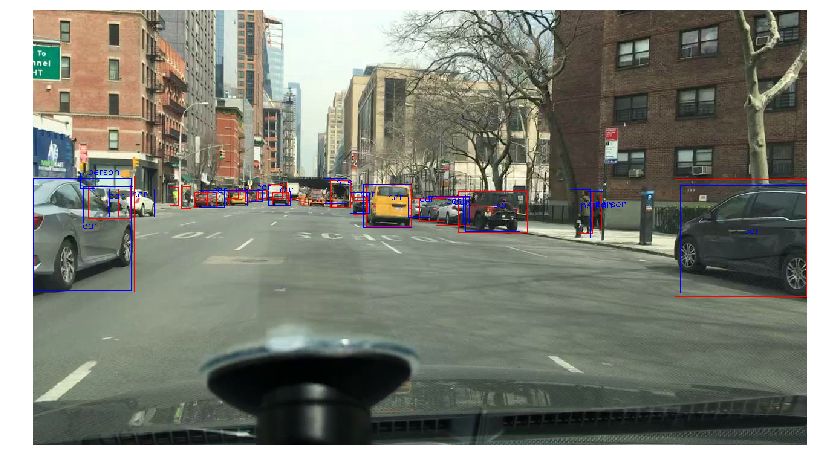

In [77]:
(img, target, img_id) = one_vid_dataset[0]
image = [img.to(device)]
output = model(image)
plot_model_output(output, image[0], target, img_id)

_, h, w = img.shape
target_boxes = target['boxes']
denorm_targets = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(target_boxes,h,w)]

loss, prediction = get_DETR_pred(img, target, img_id, model, criterion, device)
ap = compute_average_precision(prediction['boxes'], denorm_targets)
aps = compute_map(prediction, target)

In [78]:
aps

0.3660714285714286

In [11]:
# !nvidia-smi

In [10]:
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # Wrap the model with nn.DataParallel
#     model = nn.DataParallel(model)

# torch.cuda.device_count()

# # Check if CUDA (GPU support) is available
# if torch.cuda.is_available():
#     print("CUDA is available. GPUs detected: ", torch.cuda.device_count())
#     for i in range(torch.cuda.device_count()):
#         print(f"Device {i}: {torch.cuda.get_device_name(i)}")
#         print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9} GB")
# else:
#     print("CUDA is not available.")

# print(torch.__version__)

# print(torch.version.cuda)

# print("cuDNN Version:", torch.backends.cudnn.version())

In [ ]:
# torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated(), torch.cuda.memory_reserved(), torch.cuda.max_memory_reserved() 